In [7]:
from pruneshift.datamodules import ShiftDataModule
from pruneshift.networks import create_network
from pruneshift.teachers import create_teacher
from pruneshift.teachers import Teacher
from crd.criterion import CRDLoss
from torch.utils.data import DataLoader

import pandas as pd
from torchvision.datasets import ImageFolder

import random
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
import seaborn as sns
from pytorch_lightning.metrics.functional import accuracy
from matplotlib.pyplot import cm


from pathlib import Path

model_path = Path("/work/dlclarge2/hoffmaja-pruneshift/models/")
dataset_path = Path("/work/dlclarge2/hoffmaja-pruneshift/datasets/")
activation_path = Path("/work/dlclarge2/hoffmaja-pruneshift/activations/")
img100_path = dataset_path / "ILSVRC2012-100"
img100_train_path = img100_path / "train"
# data_amda_path = model_path / "/imagenetr_models/deepaugment_and_augmix.pth.tar"
data_swsl_path = activation_path / "img100_swsl_resnet50.npy"
data_amda_path = activation_path / "img100_amda_resnet50.npy"
data_std_path = activation_path / "img100_std_resnet50.npy"

In [8]:
dm_train = ShiftDataModule("imagenet", img100_path)
dm_train.setup("fit")

In [9]:
class SoftProbDataset:
    def __init__(self, activations_path, T, dataset_path=img100_train_path):
        self.dataset = ImageFolder(dataset_path)
        self.activations = create_teacher(num_classes=100, activations_path=activations_path)
        self.T = T

    def __getitem__(self, idx):
        label = self.dataset.targets[idx]
        pred = self.activations(torch.tensor(idx), None)
        probs = torch.softmax(pred / self.T, 0)

        return idx, label, probs, probs.max()

    def __len__(self):
        return len(self.dataset)

In [10]:
def gather_samples(loader, num_samples=300, sort=False):
    rows = []
    for row_num, (_, _, probs, _) in enumerate(loader):
        row = probs.numpy()

        if sort:
            row = np.sort(row, axis=1)

        rows.extend(row)

        if row_num == num_samples - 1:
            break
    return pd.DataFrame.from_records(rows)

def plot_corr(*loader):
    num_plots = loader()

In [5]:
dataset_amda = SoftProbDataset(data_amda_path, 4)
loader_amda = DataLoader(dataset_amda, batch_size=256, num_workers=3)
df = gather_samples(loader_amda, sort=True)

In [11]:
df.mean(axis=0)

0     0.002288
1     0.002555
2     0.002721
3     0.002853
4     0.002962
        ...   
95    0.022576
96    0.026216
97    0.032674
98    0.050287
99    0.236266
Length: 100, dtype: float64

In [12]:
dataset_swsl = SoftProbDataset(data_swsl_path, 4)
loader_swsl = DataLoader(dataset_swsl, batch_size=256, num_workers=3)
df = gather_samples(loader_swsl, sort=True)

In [13]:
df.mean(axis=0)

0     0.001507
1     0.001684
2     0.001801
3     0.001892
4     0.001968
        ...   
95    0.018107
96    0.021877
97    0.029085
98    0.052286
99    0.435258
Length: 100, dtype: float64

In [51]:
dataset_amda = SoftProbDataset(data_amda_path, 4)
loader_amda = DataLoader(dataset_amda, batch_size=256, num_workers=3)
dataset_swsl = SoftProbDataset(data_swsl_path, 4)
loader_swsl = DataLoader(dataset_swsl, batch_size=256, num_workers=3)

<AxesSubplot:>

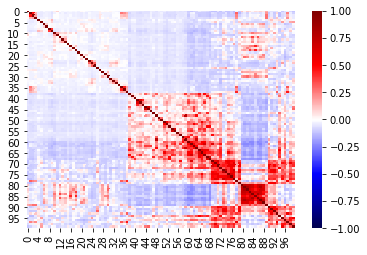

In [11]:
dataset_amda = SoftProbDataset(data_amda_path, 4)
loader_amda = DataLoader(dataset_amda, batch_size=256, num_workers=3)
df = gather_samples(loader_amda)
df_corr = df.corr()
# plt.imshow(df_corr, cmap=cm.seismic)
sns.heatmap(df_corr, vmin=-1, vmax=1, cmap=cm.seismic)

<AxesSubplot:>

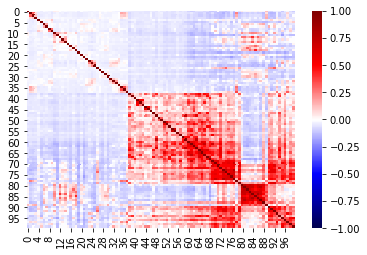

In [12]:
dataset_swsl = SoftProbDataset(data_swsl_path, 6)
loader_swsl = DataLoader(dataset_swsl, batch_size=256, num_workers=3)
df = gather_samples(loader_swsl)
df_corr = df.corr()

sns.heatmap(df_corr, vmin=-1, vmax=1, cmap=cm.seismic)

<AxesSubplot:>

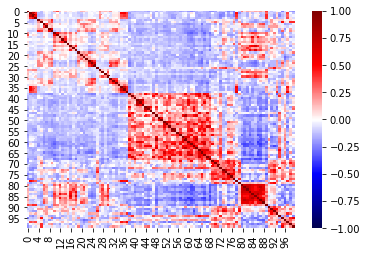

In [42]:
dataset_std = SoftProbDataset(data_std_path, 10)
loader_std = DataLoader(dataset_std, batch_size=256, num_workers=3)
df = gather_samples(loader_std)
df_corr = df.corr()
sns.heatmap(df_corr, vmin=-1, vmax=1, cmap=cm.seismic)

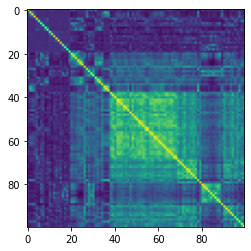

In [67]:
dataset_std = SoftProbDataset(data_std_path, 4)
loader_std = DataLoader(dataset_std, batch_size=256, num_workers=3)
df = gather_samples(loader_std)
df_corr = df.corr()
plt.imshow(df_corr)

In [93]:
def calculate_probs_distr(loader, num_bins=100):
    bins = np.linspace(0, 1, num_bins)
    counts = np.zeros(shape=len(bins) - 1, dtype=np.int64)
    for _, probs, _ in loader:
        partial_counts, _ = np.histogram(probs.numpy(), bins)
        counts += partial_counts

    return bins, counts

def plot_probs_distr(**loaders):
    for name, loader in loaders.items():
        bins, counts = calculate_probs_distr(loader)
        bin_positions = (bins[1: ] + bins[: -1]) / 2
        plt.bar(bin_positions, counts, width=1/99, alpha=0.5, label=name)
    plt.legend()

In [114]:
dataset_swsl = SoftProbDataset(data_swsl_path, 5)
loader_swsl = DataLoader(dataset_swsl, batch_size=256, num_workers=3)

In [112]:
dataset_amda = SoftProbDataset(data_amda_path, 4)
loader_amda = DataLoader(dataset_amda, batch_size=256, num_workers=3)

In [109]:
dataset_std = SoftProbDataset(data_std_path, 4)
loader_std = DataLoader(dataset_std, batch_size=256, num_workers=3)

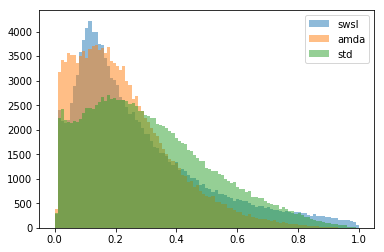

In [115]:
plot_probs_distr(swsl=loader_swsl, amda=loader_amda, std=loader_std)

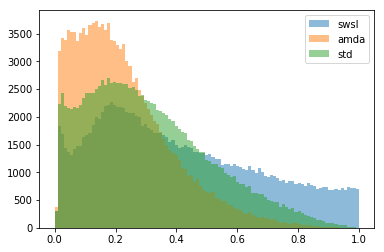

In [107]:
# T = 4
plot_probs_distr(swsl=loader_swsl, amda=loader_amda, std=loader_std)

<BarContainer object of 99 artists>

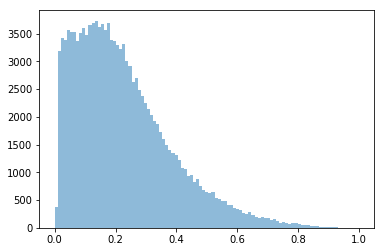

In [77]:
bin_positions = (bins[1: ] + bins[: -1]) / 2
plt.bar(bin_positions, counts, width=1/99, alpha=0.5)

In [72]:
counts

array([ 382, 3185, 3413, 3383, 3557, 3526, 3528, 3370, 3503, 3601, 3470,
       3649, 3698, 3733, 3623, 3668, 3563, 3686, 3394, 3368, 3292, 3227,
       3305, 2999, 2909, 2623, 2692, 2483, 2374, 2241, 2147, 2031, 1928,
       1879, 1726, 1598, 1500, 1407, 1356, 1321, 1218, 1081, 1059,  940,
        945,  830,  871,  760,  687,  641,  624,  639,  532,  527,  490,
        479,  409,  411,  355,  330,  312,  266,  249,  288,  230,  202,
        184,  186,  176,  169,  144,  156,  116,   93,  109,   88,   71,
         82,   78,   64,   47,   49,   43,   34,   29,   31,   21,   21,
         12,    9,    9,    7,    5,    4,    5,    0,    0,    0,    1])